In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
abx_orders = pd.read_csv('CHOC_Infusion/uci_mds_ip_abx_ords.csv')
enc = pd.read_csv("CHOC_Infusion/uci_mds_ip_enc.csv")
culture = pd.read_csv("CHOC_Infusion/uci_mds_ip_culture_ords.csv")
enc_dx = pd.read_csv("CHOC_Infusion/uci_mds_ip_enc_dx.csv")
immuno = pd.read_csv("CHOC_Infusion/uci_mds_ip_immuno_agents.csv")
lab = pd.read_csv("CHOC_Infusion/uci_mds_ip_lab_results.csv")
onc_dx = pd.read_csv("CHOC_Infusion/uci_mds_ip_onc_dx.csv")
pressor = pd.read_csv("CHOC_Infusion/uci_mds_ip_pressors_admins.csv")
vital = pd.read_csv("CHOC_Infusion/uci_mds_ip_vitals.csv")

# Data cleaning

## filter out discontinued or canceled orders

In [6]:
abx_orders_filtered = abx_orders[
    (abx_orders['ORD_STATUS'] == 'Completed') & 
    (abx_orders['DEPT_STATUS'] == 'Completed')]

abx_orders_filtered["ORD_DT"] = pd.to_datetime(abx_orders_filtered["ORD_DT"], format="%m/%d/%y %H:%M")

# drop duplicates and unnecessary info
abx_orders_filtered = abx_orders_filtered.drop_duplicates(subset=['MRN_DI', 'FIN_DI', 'ORD_DT', 'ORDERED_AS_MNEMONIC'])
abx_counts = abx_orders_filtered["ORDERED_AS_MNEMONIC"].value_counts().reset_index()

print(f"Original orders: {len(abx_orders)}")
print(f"Filtered completed orders: {len(abx_orders_filtered)}")

Original orders: 65481
Filtered completed orders: 20217


/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_27068/2577104771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abx_orders_filtered["ORD_DT"] = pd.to_datetime(abx_orders_filtered["ORD_DT"], format="%m/%d/%y %H:%M")


/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_27068/2780299606.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


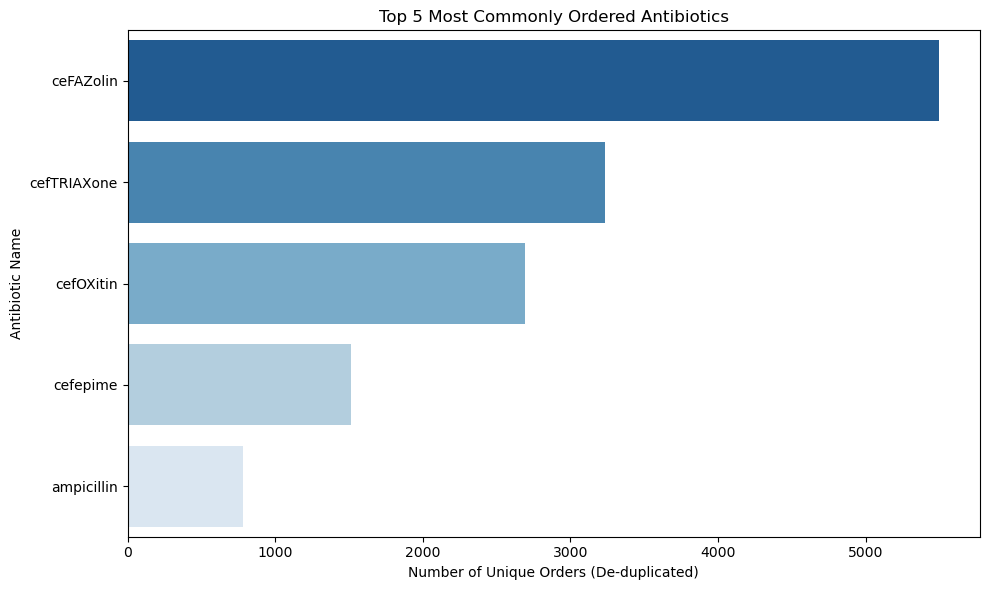

In [8]:
abx_counts.columns = ["antibiotic", "count"]
top_n = 5

plt.figure(figsize=(10, 6))
sns.barplot(
    data=abx_counts.head(top_n),
    x="count",
    y="antibiotic",
    palette="Blues_r"
)
plt.title(f"Top {top_n} Most Commonly Ordered Antibiotics")
plt.xlabel("Number of Unique Orders (De-duplicated)")
plt.ylabel("Antibiotic Name")
plt.tight_layout()
plt.show()

In [10]:
cefazolin_orders = abx_orders_filtered[
    abx_orders_filtered["ORDERED_AS_MNEMONIC"] == "ceFAZolin"
].copy()

print(f"Number of ceFAZolin orders: {len(cefazolin_orders)}")
print(f"Unique patients: {cefazolin_orders['MRN_DI'].nunique()}")
print(f"Unique visits: {cefazolin_orders[['MRN_DI', 'FIN_DI']].drop_duplicates().shape[0]}")

Number of ceFAZolin orders: 5500
Unique patients: 3750
Unique visits: 4151


In [12]:
# Ensure ORD_DT is datetime
cefazolin_orders["ORD_DT"] = pd.to_datetime(cefazolin_orders["ORD_DT"])

# Take most recent order per patient
cefazolin_latest = (
    cefazolin_orders.sort_values("ORD_DT", ascending=False)
    .groupby("MRN_DI")
    .first()
    .reset_index()
)

print(f"Number of ceFAZolin orders: {len(cefazolin_latest)}")
print(f"Unique patients: {cefazolin_latest['MRN_DI'].nunique()}")
print(f"Unique visits: {cefazolin_latest[['MRN_DI', 'FIN_DI']].drop_duplicates().shape[0]}")

cefazolin_latest.drop(columns=["ORDER_ID", "CATALOG_DISP","ORDERED_AS_MNEMONIC","ORD_STATUS","DEPT_STATUS"], inplace=True)

Number of ceFAZolin orders: 3750
Unique patients: 3750
Unique visits: 3750


## merge the abx orders with the encounter to calculate delay

In [15]:
enc["REG_DT"] = pd.to_datetime(enc["REG_DT"], format="%m/%d/%y %H:%M")
enc.drop(columns=["DISCH_DT","SEX","RACE","ETHNICITY","SEASON","DISCH_DISPO"], inplace=True)

X = cefazolin_latest.merge(enc, on=['MRN_DI', 'FIN_DI'], how='left')
X["delayed_hours"] = (X["ORD_DT"] - X["REG_DT"]).dt.total_seconds() / 3600
X = X[(X["delayed_hours"] >= 0) & (X["delayed_hours"] <= 48)]

In [17]:
X["delayed_hours"].describe()

count    3009.000000
mean       10.660995
std         9.034809
min         0.116667
25%         5.066667
50%         7.233333
75%        12.983333
max        47.766667
Name: delayed_hours, dtype: float64

In [19]:
abx_count_per_encounter = X.groupby(['MRN_DI', 'FIN_DI']).size().reset_index(name='num_abx_orders')

abx_count_per_encounter = abx_count_per_encounter.sort_values('num_abx_orders', ascending=False)

abx_count_per_encounter.describe()

,num_abx_orders
count,3009.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


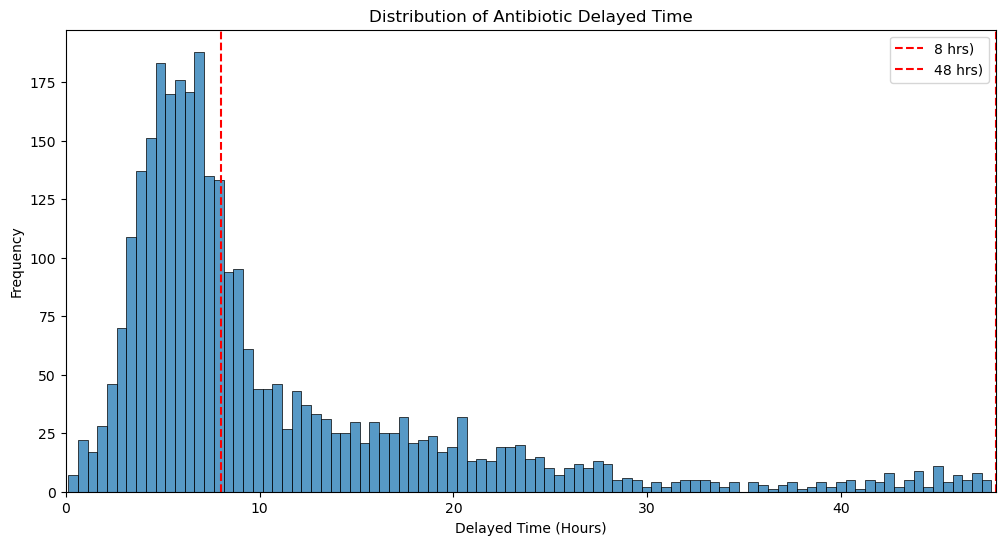

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(X["delayed_hours"], binwidth=0.5, edgecolor='black', linewidth=0.5 )

plt.xlim(0, 48)
plt.xlabel("Delayed Time (Hours)")
plt.ylabel("Frequency")
plt.title("Distribution of Antibiotic Delayed Time")

plt.axvline(x=8, color='red', linestyle='--', label='8 hrs)')
#plt.axvline(x=12, color='red', linestyle='--', label='12 hrs)')
#plt.axvline(x=24, color='purple', linestyle='--', label='24 hrs)')
plt.axvline(x=48, color='red', linestyle='--', label='48 hrs)')

plt.legend()
plt.show()

In [23]:
X.shape

(3009, 5)

# Feature engineering

## culture orders

In [27]:
culture['ORD_DT'] = pd.to_datetime(culture['ORD_DT'])

def culture_features(row):
    mrn = row['MRN_DI']
    fin = row['FIN_DI']
    abx_time = row['ORD_DT']

    subset = culture[
        (culture['MRN_DI'] == mrn) & 
        (culture['FIN_DI'] == fin)
    ]
    
    # Filter only cultures ordered before or at the antibiotic order
    subset_before = subset[subset['ORD_DT'] <= abx_time]
    
    blood_culture = int(any(subset_before['HNA_ORDER_MNEMONIC'].str.contains('Blood Culture', case=False, na=False)))
    urine_culture = int(any(subset_before['HNA_ORDER_MNEMONIC'].str.contains('Urine Culture', case=False, na=False)))
    
    return pd.Series([blood_culture, urine_culture])

/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_27068/2949724938.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  culture['ORD_DT'] = pd.to_datetime(culture['ORD_DT'])


In [29]:
X[['blood_culture_before_antibiotic', 'urine_culture_before_antibiotic']] = X.apply(culture_features, axis=1)

In [30]:
X.head()

,MRN_DI,FIN_DI,ORD_DT,REG_DT,delayed_hours,blood_culture_before_antibiotic,urine_culture_before_antibiotic
0,00024D446DF59BEE090F58743FF91A,6E443A25E3988AA9388E16A22326F2,2024-03-07 00:05:00,2024-03-06 16:43:00,7.366667,0,0
2,002183404FD35E5DC410854A8BABAB,47903818F6C128F594E5FAC0BDBAE5,2023-09-26 06:09:00,2023-09-26 01:42:00,4.450000,0,0
3,0050F35C7D83941FA5C4E50F168FB6,1ED95399468E525F5ECC292B1AF050,2023-03-19 03:51:00,2023-03-19 01:20:00,2.516667,1,0
4,0078E7041E91D28393215D132AF20F,C377EC9D2445C510F0905B82AA2737,2023-04-14 10:45:00,2023-04-13 08:53:00,25.866667,0,0
5,00835CFC5318D3131309F61529DB35,D519A919202FD56D925945371DF913,2024-01-20 17:26:00,2024-01-20 02:24:00,15.033333,0,0


In [31]:
X["time_to_culture"] = (X["ORD_DT"] - X[["MRN_DI", "FIN_DI"]].merge(
    culture.groupby(["MRN_DI", "FIN_DI"])["ORD_DT"].min().reset_index(), 
    on=["MRN_DI", "FIN_DI"],
    how="left")["ORD_DT"]
).dt.total_seconds() / 3600

X["time_to_culture"] = X["time_to_culture"].fillna(-1)

## Encounter source identifier

In [33]:
def infection_features(diagnosis_list):
    diagnosis_list = [str(code) for code in diagnosis_list]
    
    has_infectious_disease = int(any(code.startswith(('A', 'B')) for code in diagnosis_list))
    
    has_respiratory_infection = int(any(code.startswith('J0') or code.startswith('J1') or code.startswith('J2') for code in diagnosis_list))
    
    has_pneumonia = int(any(code.startswith('J12') or code.startswith('J13') or code.startswith('J14') or code.startswith('J15') or code.startswith('J16') or code.startswith('J17') or code.startswith('J18') for code in diagnosis_list))
    
    has_sepsis = int(any(code.startswith('A40') or code.startswith('A41') for code in diagnosis_list))
    
    has_urinary_infection = int(any(code.startswith('N10') or code.startswith('N11') or code.startswith('N12') for code in diagnosis_list))
    
    has_cns_infection = int(any(code.startswith('G00') or code.startswith('G01') or code.startswith('G02') or code.startswith('G03') or code.startswith('G04') or code.startswith('G05') or code.startswith('G06') or code.startswith('G07') or code.startswith('G08') or code.startswith('G09') for code in diagnosis_list))
    
    has_skin_infection = int(any(code.startswith('L00') or code.startswith('L01') or code.startswith('L02') or code.startswith('L03') or code.startswith('L04') or code.startswith('L05') or code.startswith('L06') or code.startswith('L07') or code.startswith('L08') for code in diagnosis_list))
    
    return pd.Series([has_infectious_disease, has_respiratory_infection, has_pneumonia, has_sepsis, has_urinary_infection, has_cns_infection, has_skin_infection])

In [34]:
enc_dx_grouped = enc_dx.groupby(['MRN_DI', 'FIN_DI'])['SOURCE_IDENTIFIER'].apply(list).reset_index()
enc_dx_grouped[['has_infectious_disease', 'has_respiratory_infection', 'has_pneumonia',
                'has_sepsis', 'has_urinary_infection', 'has_cns_infection', 'has_skin_infection']] = enc_dx_grouped['SOURCE_IDENTIFIER'].apply(infection_features)

In [35]:
X = X.merge(
    enc_dx_grouped[['MRN_DI', 'FIN_DI', 'has_infectious_disease', 'has_respiratory_infection', 
                    'has_pneumonia', 'has_sepsis', 'has_urinary_infection', 
                    'has_cns_infection', 'has_skin_infection']],
    on=['MRN_DI', 'FIN_DI'],
    how='left')

In [36]:
X.shape

(3009, 15)

In [41]:
X.head()

,MRN_DI,FIN_DI,ORD_DT,REG_DT,delayed_hours,blood_culture_before_antibiotic,urine_culture_before_antibiotic,time_to_culture,has_infectious_disease,has_respiratory_infection,has_pneumonia,has_sepsis,has_urinary_infection,has_cns_infection,has_skin_infection
0,00024D446DF59BEE090F58743FF91A,6E443A25E3988AA9388E16A22326F2,2024-03-07 00:05:00,2024-03-06 16:43:00,7.366667,0,0,-1.000000,0,0,0,0,0,0,0
1,002183404FD35E5DC410854A8BABAB,47903818F6C128F594E5FAC0BDBAE5,2023-09-26 06:09:00,2023-09-26 01:42:00,4.450000,0,0,4587.283333,0,0,0,0,0,0,0
2,0050F35C7D83941FA5C4E50F168FB6,1ED95399468E525F5ECC292B1AF050,2023-03-19 03:51:00,2023-03-19 01:20:00,2.516667,1,0,-1.000000,0,0,0,0,0,0,0
3,0078E7041E91D28393215D132AF20F,C377EC9D2445C510F0905B82AA2737,2023-04-14 10:45:00,2023-04-13 08:53:00,25.866667,0,0,-1.000000,0,0,0,0,0,0,0
4,00835CFC5318D3131309F61529DB35,D519A919202FD56D925945371DF913,2024-01-20 17:26:00,2024-01-20 02:24:00,15.033333,0,0,-1.000000,0,0,0,0,0,0,0


## Immuno agents

In [43]:
# only take completed immuno
immuno = immuno[(immuno['ORD_STATUS'] == 'Completed') & (immuno['DEPT_STATUS'] == 'Completed')]
immuno['ORD_DT'] = pd.to_datetime(immuno['ORD_DT'])

/var/folders/vz/tk38nmzj5xd05b2t1bmzsy2h0000gn/T/ipykernel_27068/550632086.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  immuno['ORD_DT'] = pd.to_datetime(immuno['ORD_DT'])


In [49]:
def immuno_features(row):
    mrn = row['MRN_DI']
    fin = row['FIN_DI']
    abx_time = row['ORD_DT']
    
    subset = immuno[
        (immuno['MRN_DI'] == mrn) & 
        (immuno['FIN_DI'] == fin)
    ]
    
    subset_before = subset[subset['ORD_DT'] <= abx_time]
    
    # General vaccine feature
    any_immuno = int(len(subset_before) > 0)
    
    # Specific vaccines
    pneumococcal = int(any(subset_before['ORDERED_AS_MNEMONIC'].str.contains('Prevnar', case=False, na=False)))
    hib = int(any(subset_before['ORDERED_AS_MNEMONIC'].str.contains('HibTITER', case=False, na=False)))
    
    return pd.Series([any_immuno, pneumococcal, hib])

In [51]:
X[['any_immuno_before_antibiotic', 'pneumococcal_vaccine_before_antibiotic',
   'hib_vaccine_before_antibiotic',]] = X.apply(immuno_features, axis=1)

In [52]:
X['any_immuno_before_antibiotic'].describe()

count    3009.000000
mean        0.011299
std         0.105714
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: any_immuno_before_antibiotic, dtype: float64

In [53]:
X.shape

(3009, 18)

## Lab result

In [58]:
print(lab['EVENT'].unique())
print(f"Total unique lab event types: {lab['EVENT'].nunique()}")

['Platelet Count' 'White Blood Cell Count' 'Urine Clarity'
 'Urine Leukocyte Esterase' 'Urine Nitrite' 'C-Reactive Protein'
 'Urine WBC' 'CSF Culture (CSF)' 'Erythrocyte Sedimentation Rate'
 'Absolute Neutrophil Count']
Total unique lab event types: 10


In [60]:
for event in lab['EVENT'].unique():
    subset = lab[lab['EVENT'] == event]
    print(f"--- {event} ---")
    print(subset['RESULT_VAL'].unique()[:20])
    print("\n")

--- Platelet Count ---
['176' '318' '245' '214' '155' '303' '200' '173' '157' '139' '260' '150'
 '411' '481' '386' '434' '373' '151' '223' '177']


--- White Blood Cell Count ---
['6.4' '8.5' '6.8' '6.7' '5.0' '9.5' '14.1' '17.9' '3.7' '4.0' '3.0'
 '15.8' '15.0' '12.0' '9.0' '7.2' '10.1' '12.7' '11.4' '4.9']


--- Urine Clarity ---
['Turbid' 'Clear' 'Hazy' 'Slightly Hazy' 'Cloudy' 'Slightly Cloudy'
 'See Comment' 'Bloody' 'see comment' 'Error' 'See comment'
 'slightly hazy']


--- Urine Leukocyte Esterase ---
['Negative' 'Trace' '2+' '3+' 'Large' '1+' 'See Comment' 'see comment'
 'Moderate' 'Small' 'See comment']


--- Urine Nitrite ---
['Negative' 'Positive' 'See Comment' 'see comment' 'See comment']


--- C-Reactive Protein ---
['<5.0' '14.6' '21.7' '9.6' '5.2' '45.4' '17.7' '26.2' '18.2' '14.8'
 '21.3' '8.1' '7.2' '29.0' '11.9' '21.2' '6.3' '10.9' '17.1' '32.7']


--- Urine WBC ---
['8' '<4' '5' 'None Seen' '167' '21-30' '>182' '50-74' '39' '4' '19' '11'
 '69' '10' '7' '29' '55' '46

In [62]:
continuous_events = [
    'Platelet Count',
    'White Blood Cell Count',
    'C-Reactive Protein',
    'Urine WBC',
    'Erythrocyte Sedimentation Rate',
    'Absolute Neutrophil Count'
]

In [64]:
def clean_continuous_result(val):
    if pd.isnull(val):
        return np.nan
    val = str(val).strip()
    
    # Handle "<" and ">"
    val = val.replace('<', '').replace('>', '').strip()
    
    # Handle ranges like "21-30"
    if '-' in val:
        parts = val.split('-')
        try:
            nums = [float(p) for p in parts]
            return sum(nums) / len(nums)
        except:
            return np.nan
    
    # Try converting to float
    try:
        return float(val)
    except:
        return np.nan

In [66]:
# Apply to continuous events
lab['RESULT_VAL_NUMERIC'] = np.where(
    lab['EVENT'].isin(continuous_events),
    lab['RESULT_VAL'].apply(clean_continuous_result),
    np.nan  # for now, leave non-continuous events as NaN
)

In [68]:
categorical_events = [
    'Urine Clarity',
    'Urine Leukocyte Esterase',
    'Urine Nitrite'
]

In [70]:
def clean_categorical_result(event, val):
    if pd.isnull(val):
        return np.nan
    val = str(val).strip().lower()

    # Handle missing/error values
    if val in ['see comment', 'see comments', 'error', 'none seen']:
        return np.nan

    # Urine Clarity (0–3 scale)
    if event == 'Urine Clarity':
        if val == 'clear':
            return 0
        elif val in ['slightly hazy', 'slightly cloudy']:
            return 1
        elif val in ['hazy', 'cloudy']:
            return 2
        elif val in ['turbid', 'bloody']:
            return 3
        else:
            return np.nan
    
    # Urine Leukocyte Esterase (0–4 scale)
    elif event == 'Urine Leukocyte Esterase':
        if val == 'negative':
            return 0
        elif val == 'trace':
            return 1
        elif val == '1+':
            return 2
        elif val == '2+':
            return 3
        elif val in ['3+', 'large', 'moderate', 'small']:
            return 4
        else:
            return np.nan
    
    # Urine Nitrite (0/1 binary)
    elif event == 'Urine Nitrite':
        if val == 'negative':
            return 0
        elif val == 'positive':
            return 1
        else:
            return np.nan
    
    # Default fallback
    else:
        return np.nan

In [72]:
lab['RESULT_VAL_CATEGORICAL'] = np.where(
    lab['EVENT'].isin(['Urine Clarity', 'Urine Leukocyte Esterase', 'Urine Nitrite']),
    lab.apply(lambda row: clean_categorical_result(row['EVENT'], row['RESULT_VAL']), axis=1),
    np.nan
)

In [73]:
lab[['EVENT', 'RESULT_VAL', 'RESULT_VAL_NUMERIC', 'RESULT_VAL_CATEGORICAL']].sample(20)

,EVENT,RESULT_VAL,RESULT_VAL_NUMERIC,RESULT_VAL_CATEGORICAL
113616,Urine Clarity,Clear,NaN,0.0
271854,Urine Leukocyte Esterase,Negative,NaN,0.0
144989,White Blood Cell Count,3.5,3.5,NaN
122052,Erythrocyte Sedimentation Rate,59,59.0,NaN
11697,Urine Clarity,Clear,NaN,0.0
37908,Urine Leukocyte Esterase,Negative,NaN,0.0
216629,C-Reactive Protein,22.0,22.0,NaN
76347,Erythrocyte Sedimentation Rate,67,67.0,NaN
146211,Erythrocyte Sedimentation Rate,39,39.0,NaN
114710,Platelet Count,481,481.0,NaN


In [76]:
def lab_features(row):
    mrn = row['MRN_DI']
    fin = row['FIN_DI']
    abx_time = row['ORD_DT']

    subset = lab[
        (lab['MRN_DI'] == mrn) &
        (lab['FIN_DI'] == fin)
    ]
    

    #subset_before = subset[pd.to_datetime(subset['EVENT_END_DT_TM']) <= abx_time]
    subset_before = subset.copy()

    # Continuous labs
    platelet_series = subset_before[subset_before['EVENT'] == 'Platelet Count']['RESULT_VAL_NUMERIC']
    platelet_latest_val = platelet_series.sort_index(ascending=False).iloc[0] if not platelet_series.empty else np.nan

    wbc_mean = subset_before[subset_before['EVENT'] == 'White Blood Cell Count']['RESULT_VAL_NUMERIC'].mean()
    crp_mean = subset_before[subset_before['EVENT'] == 'C-Reactive Protein']['RESULT_VAL_NUMERIC'].mean()
    urine_wbc_mean = subset_before[subset_before['EVENT'] == 'Urine WBC']['RESULT_VAL_NUMERIC'].mean()

    esr_series = subset_before[subset_before['EVENT'] == 'Erythrocyte Sedimentation Rate']['RESULT_VAL_NUMERIC']
    esr_latest_val = esr_series.sort_index(ascending=False).iloc[0] if not esr_series.empty else np.nan

    anc_mean = subset_before[subset_before['EVENT'] == 'Absolute Neutrophil Count']['RESULT_VAL_NUMERIC'].mean()

    # Categorical labs
    urine_clarity_mean = subset_before[subset_before['EVENT'] == 'Urine Clarity']['RESULT_VAL_CATEGORICAL'].mean()
    urine_leukocyte_mean = subset_before[subset_before['EVENT'] == 'Urine Leukocyte Esterase']['RESULT_VAL_CATEGORICAL'].mean()
    urine_nitrite_mean = subset_before[subset_before['EVENT'] == 'Urine Nitrite']['RESULT_VAL_CATEGORICAL'].mean()

    return pd.Series({
        'platelet_latest': platelet_latest_val,
        'wbc_mean': wbc_mean,
        'crp_mean': crp_mean,
        'urine_wbc_mean': urine_wbc_mean,
        'esr_latest': esr_latest_val,
        'anc_mean': anc_mean,
        'urine_clarity_mean': urine_clarity_mean,
        'urine_leukocyte_mean': urine_leukocyte_mean,
        'urine_nitrite_mean': urine_nitrite_mean
    })

In [78]:
X[['platelet_latest',
        'wbc_mean',
        'crp_mean',
        'urine_wbc_mean',
        'esr_latest',
        'anc_mean',
        'urine_clarity_mean',
        'urine_leukocyte_mean',
        'urine_nitrite_mean']] = X.apply(lab_features, axis=1)

In [79]:
lab_feature_cols = [
    'platelet_latest',
    'wbc_mean',
    'crp_mean',
    'urine_wbc_mean',
    'esr_latest',
    'anc_mean',
    'urine_clarity_mean',
    'urine_leukocyte_mean',
    'urine_nitrite_mean'
]

no_lab_rows = X[lab_feature_cols].isna().all(axis=1)
print(f"Number of encounters with ALL lab results missing: {no_lab_rows.sum()}")
X = X[~no_lab_rows].reset_index(drop=True)

Number of encounters with ALL lab results missing: 1346


In [80]:
print(f"After dropping, new shape: {X.shape}")

After dropping, new shape: (1663, 27)


In [81]:
X[['platelet_latest',
    'wbc_mean',
    'crp_mean',
    'urine_wbc_mean',
    'esr_latest',
    'anc_mean',
    'urine_clarity_mean',
    'urine_leukocyte_mean',
    'urine_nitrite_mean']] = \
X[['platelet_latest',
    'wbc_mean',
    'crp_mean',
    'urine_wbc_mean',
    'esr_latest',
    'anc_mean',
    'urine_clarity_mean',
    'urine_leukocyte_mean',
    'urine_nitrite_mean']].fillna(-1)

In [82]:
X["wbc_high"] = (X["wbc_mean"] > 12).astype(int)
X["crp_very_high"] = (X["crp_mean"] > 100).astype(int)

In [83]:
X.head()

,MRN_DI,FIN_DI,ORD_DT,REG_DT,delayed_hours,blood_culture_before_antibiotic,urine_culture_before_antibiotic,time_to_culture,has_infectious_disease,has_respiratory_infection,...,wbc_mean,crp_mean,urine_wbc_mean,esr_latest,anc_mean,urine_clarity_mean,urine_leukocyte_mean,urine_nitrite_mean,wbc_high,crp_very_high
0,00024D446DF59BEE090F58743FF91A,6E443A25E3988AA9388E16A22326F2,2024-03-07 00:05:00,2024-03-06 16:43:00,7.366667,0,0,-1.000000,0,0,...,15.10,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0
1,002183404FD35E5DC410854A8BABAB,47903818F6C128F594E5FAC0BDBAE5,2023-09-26 06:09:00,2023-09-26 01:42:00,4.450000,0,0,4587.283333,0,0,...,14.58,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,1,0
2,0050F35C7D83941FA5C4E50F168FB6,1ED95399468E525F5ECC292B1AF050,2023-03-19 03:51:00,2023-03-19 01:20:00,2.516667,1,0,-1.000000,0,0,...,11.00,5.0,4.0,27.0,-1.0,0.0,0.0,0.0,0,0
3,00907617EA38CB8480533736496A27,76D4B2AE3F4E04F0AFD155C21D3570,2023-06-14 00:55:00,2023-06-13 20:12:00,4.716667,0,0,-1.000000,0,0,...,12.05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0
4,009C4952EF562C9C1C9AB5F11EF03A,6B4445C119763D46490B99004F616E,2023-08-19 20:33:00,2023-08-19 15:39:00,4.900000,0,0,8223.583333,0,0,...,6.60,64.8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0


## Oncology source identifier

In [85]:
def oncology_features(diagnosis_list):
    diagnosis_list = [str(code) for code in diagnosis_list]  # Ensure all are strings

    has_cancer = int(any(code.startswith('C') for code in diagnosis_list))
    has_hematologic_malignancy = int(any(
        code.startswith(('C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96'))
        for code in diagnosis_list
    ))
    has_chemo_status = int(any(
        code.startswith(('Z51.11', 'Z92.21'))
        for code in diagnosis_list
    ))
    has_transplant_status = int(any(
        code.startswith(('Z94.81', 'T86.00', 'T86.09'))
        for code in diagnosis_list
    ))
    has_tumor_lysis_risk = int(any(
        code.startswith('E88.3') for code in diagnosis_list
    ))
    has_pancytopenia = int(any(
        code.startswith('D61.810') for code in diagnosis_list
    ))
    has_followup_after_chemo = int(any(
        code.startswith(('Z08', 'Z48.290')) for code in diagnosis_list
    ))
    has_neutropenia = int(any(
        code.startswith('D70') for code in diagnosis_list
    ))

    return pd.Series([
        has_cancer,
        has_hematologic_malignancy,
        has_chemo_status,
        has_transplant_status,
        has_tumor_lysis_risk,
        has_pancytopenia,
        has_followup_after_chemo,
        has_neutropenia
    ])

In [86]:
onc_dx_grouped = onc_dx.groupby(['MRN_DI'])['SOURCE_IDENTIFIER'].apply(list).reset_index()
onc_dx_grouped[['has_cancer',
                'has_hematologic_malignancy',
                'has_chemo_status',
                'has_transplant_status',
                'has_tumor_lysis_risk',
                'has_pancytopenia',
                'has_followup_after_chemo',
                'has_neutropenia']] = onc_dx_grouped['SOURCE_IDENTIFIER'].apply(oncology_features)

In [87]:
X = X.merge(
    onc_dx_grouped[['MRN_DI',
                    'has_cancer', 'has_hematologic_malignancy', 'has_chemo_status',
                    'has_transplant_status', 'has_tumor_lysis_risk', 'has_pancytopenia',
                    'has_followup_after_chemo', 'has_neutropenia']],
    on=['MRN_DI'],
    how='left'
)

In [88]:
X.shape

(1663, 37)

In [89]:
X.isnull().sum()

MRN_DI                                       0
FIN_DI                                       0
ORD_DT                                       0
REG_DT                                       0
delayed_hours                                0
blood_culture_before_antibiotic              0
urine_culture_before_antibiotic              0
time_to_culture                              0
has_infectious_disease                       0
has_respiratory_infection                    0
has_pneumonia                                0
has_sepsis                                   0
has_urinary_infection                        0
has_cns_infection                            0
has_skin_infection                           0
any_immuno_before_antibiotic                 0
pneumococcal_vaccine_before_antibiotic       0
hib_vaccine_before_antibiotic                0
platelet_latest                              0
wbc_mean                                     0
crp_mean                                     0
urine_wbc_mea

In [90]:
X.drop(columns=['has_cancer', 'has_hematologic_malignancy', 'has_chemo_status',
                    'has_transplant_status', 'has_tumor_lysis_risk', 'has_pancytopenia',
                    'has_followup_after_chemo', 'has_neutropenia'], inplace=True)

Too much null values for oncology features, decide not to use it.

## Pressors

In [93]:
pressor_use = pressor.groupby(['MRN_DI', 'FIN_DI']).size().reset_index(name='pressor_administered')
pressor_use['pressor_administered'] = 1 

In [94]:
X = X.merge(pressor_use[['MRN_DI', 'FIN_DI', 'pressor_administered']], on=['MRN_DI', 'FIN_DI'], how='left')
X['pressor_administered'] = X['pressor_administered'].fillna(0).astype(int)

In [95]:
print("Number of patients without any pressor:", (X['pressor_administered'] == 0).sum())
print("Number of patients who received pressor:", (X['pressor_administered'] == 1).sum())

Number of patients without any pressor: 1535
Number of patients who received pressor: 128


In [96]:
X.shape

(1663, 30)

## Vitals

In [98]:
print(vital['EVENT'].unique())
for event in vital['EVENT'].unique():
    subset = vital[vital['EVENT'] == event]
    print(f"--- {event} ---")
    print(subset['RESULT_VAL'].unique()[:10])
    print("\n")

['NIBP-Systolic (mmHg)' 'NIBP-Diastolic (mmHg)' 'Heart Rate (BPM)']
--- NIBP-Systolic (mmHg) ---
[102 115 108 112  96 119 103 100 105 111]


--- NIBP-Diastolic (mmHg) ---
[74 60 66 55 61 64 73 76 72 87]


--- Heart Rate (BPM) ---
[125  93  98  90 108  76 113 107  94  84]




In [99]:
vital['RESULT_VAL'] = pd.to_numeric(vital['RESULT_VAL'], errors='coerce')
vital['EVENT_END_DT_TM'] = pd.to_datetime(vital['EVENT_END_DT_TM'], format='%m/%d/%y %H:%M', errors='coerce')
vital_grouped = vital.groupby(['MRN_DI', 'FIN_DI'])

In [100]:
def vital_features(row):
    mrn = row['MRN_DI']
    fin = row['FIN_DI']
    abx_time = row['ORD_DT']
    
    if (mrn, fin) not in vital_grouped.groups:
        return pd.Series({
            'heart_rate_mean': np.nan,
            'heart_rate_std': np.nan,
            'sbp_mean': np.nan,
            'sbp_std': np.nan,
            'dbp_mean': np.nan,
            'dbp_std': np.nan,
            'has_tachycardia': 0,
            'has_hypotension': 0,
            'has_low_dbp': 0
        })
    
    subset = vital_grouped.get_group((mrn, fin))
    #subset_before = subset[subset['EVENT_END_DT_TM'] <= abx_time] # all of the vitals comes after abx_order
    subset_before = subset.copy()
    
    features = {}
    
    for vital_type, short in [
        ('Heart Rate (BPM)', 'heart_rate'),
        ('NIBP-Systolic (mmHg)', 'sbp'),
        ('NIBP-Diastolic (mmHg)', 'dbp')
    ]:
        vital_series = subset_before[subset_before['EVENT'] == vital_type]['RESULT_VAL']
        vital_series = pd.to_numeric(vital_series, errors='coerce')
        
        features[f'{short}_mean'] = vital_series.mean()
        features[f'{short}_std'] = vital_series.std()
        
        if vital_type == 'Heart Rate (BPM)':
            features['has_tachycardia'] = int(((vital_series.dropna()) > 100).any()) if not vital_series.dropna().empty else 0
        elif vital_type == 'NIBP-Systolic (mmHg)':
            features['has_hypotension'] = int(((vital_series.dropna()) < 90).any()) if not vital_series.dropna().empty else 0
        elif vital_type == 'NIBP-Diastolic (mmHg)':
            features['has_low_dbp'] = int(((vital_series.dropna()) < 60).any()) if not vital_series.dropna().empty else 0
    
    return pd.Series(features)

In [101]:
vital_feats = X.apply(vital_features, axis=1)
X = pd.concat([X, vital_feats], axis=1)

In [102]:
X.shape

(1663, 39)

In [103]:
print(X[['heart_rate_mean', 'sbp_mean', 'dbp_mean', 
  'has_tachycardia', 'has_hypotension', 'has_low_dbp']].head())

   heart_rate_mean    sbp_mean   dbp_mean  has_tachycardia  has_hypotension  \
0       125.563636  107.095238  64.214286              1.0              1.0   
1        89.095238  126.142857  71.102041              1.0              1.0   
2        89.000000  105.909091  55.909091              1.0              0.0   
3        87.373832   97.741935  57.731183              1.0              1.0   
4       134.379310   88.974138  50.525862              1.0              1.0   

   has_low_dbp  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


In [104]:
X[['has_tachycardia', 'has_hypotension', 'has_low_dbp']].describe()

,has_tachycardia,has_hypotension,has_low_dbp
count,1663.000000,1663.000000,1663.000000
mean,0.875526,0.868912,0.993385
std,0.330221,0.337599,0.081085
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [105]:
X = X.dropna().reset_index(drop=True)

## registration time

In [107]:
X["reg_hour"] = X["REG_DT"].dt.hour
X["reg_shift"] = pd.cut(
    X["reg_hour"],
    bins=[0, 7, 15, 24],
    labels=["Night", "Day", "Evening"],
    right=False
)

X = pd.get_dummies(X, columns=["reg_shift"], drop_first=True)

bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype(int)


# Day of week from registration time
X["reg_weekday"] = X["REG_DT"].dt.dayofweek  # 0=Monday
X["reg_month"] = X["REG_DT"].dt.month

In [108]:
X.head(50)

,MRN_DI,FIN_DI,ORD_DT,REG_DT,delayed_hours,blood_culture_before_antibiotic,urine_culture_before_antibiotic,time_to_culture,has_infectious_disease,has_respiratory_infection,...,sbp_std,has_hypotension,dbp_mean,dbp_std,has_low_dbp,reg_hour,reg_shift_Day,reg_shift_Evening,reg_weekday,reg_month
0,00024D446DF59BEE090F58743FF91A,6E443A25E3988AA9388E16A22326F2,2024-03-07 00:05:00,2024-03-06 16:43:00,7.366667,0,0,-1.000000,0,0,...,12.038170,1.0,64.214286,7.333637,1.0,16,0,1,2,3
1,002183404FD35E5DC410854A8BABAB,47903818F6C128F594E5FAC0BDBAE5,2023-09-26 06:09:00,2023-09-26 01:42:00,4.450000,0,0,4587.283333,0,0,...,15.848239,1.0,71.102041,12.675838,1.0,1,0,0,1,9
2,0050F35C7D83941FA5C4E50F168FB6,1ED95399468E525F5ECC292B1AF050,2023-03-19 03:51:00,2023-03-19 01:20:00,2.516667,1,0,-1.000000,0,0,...,8.502406,0.0,55.909091,10.377423,1.0,1,0,0,6,3
3,00907617EA38CB8480533736496A27,76D4B2AE3F4E04F0AFD155C21D3570,2023-06-14 00:55:00,2023-06-13 20:12:00,4.716667,0,0,-1.000000,0,0,...,11.595448,1.0,57.731183,10.260879,1.0,20,0,1,1,6
4,009C4952EF562C9C1C9AB5F11EF03A,6B4445C119763D46490B99004F616E,2023-08-19 20:33:00,2023-08-19 15:39:00,4.900000,0,0,8223.583333,0,0,...,22.970098,1.0,50.525862,19.897765,1.0,15,0,1,5,8
5,00CAB57978F6F919B87226D414D77A,F5640D5654295FA161CEB49A66A126,2022-09-12 06:19:00,2022-09-11 04:56:00,25.383333,0,1,-1.000000,0,0,...,15.574089,1.0,58.083333,11.697155,1.0,4,0,0,6,9
6,01BF81D013A459F17390E8F086B65F,7B2A8169C7AC3D27C3403ACFBF5861,2023-03-14 06:59:00,2023-03-14 01:35:00,5.400000,0,0,-1.000000,0,0,...,15.642194,1.0,68.472441,13.803721,1.0,1,0,0,1,3
7,0236A2DA13D05CC79B5BC701008D4A,05263A5B792A74557F8159A27C96D5,2023-02-12 01:07:00,2023-02-11 16:07:00,9.000000,0,0,2095.800000,1,0,...,15.126270,1.0,51.221125,13.400138,1.0,16,0,1,5,2
8,0241FE09087C4C51D9C553E466B926,BE9ED3C96D1A451BD7BAE0198BB156,2023-02-16 01:31:00,2023-02-15 19:16:00,6.250000,0,1,-1.000000,0,0,...,16.460362,1.0,54.686275,16.906200,1.0,19,0,1,2,2
9,027366A7E3E9E095B36BEC748DC7A2,C1BD63E47E6ADCD2A87CA726037766,2023-06-04 18:44:00,2023-06-04 16:04:00,2.666667,0,0,-1.000000,1,0,...,9.844487,1.0,52.013514,12.764992,1.0,16,0,1,6,6


## Interaction features

In [110]:
X["sepsis_x_crp"] = X["has_sepsis"] * X["crp_mean"]
X["wbc_crp_interaction"] = X["wbc_mean"] * X["crp_mean"]

In [111]:
X.shape

(1662, 46)

In [112]:
X.to_csv("Processed_data.csv", index=False)